In [14]:
import re
import numpy as np
import pandas as pd
from scipy import sparse
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from wordcloud import WordCloud

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.base import BaseEstimator

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import log_loss, confusion_matrix

from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, SelectPercentile

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.externals import joblib

In [16]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [17]:
# the docker container is too small to run the gridsearch
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


## read data

In [59]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [60]:
classes = [x for x in train.columns if x not in ['id', 'comment_text']]

In [61]:
test.fillna('emptycomment', inplace=True)
train.fillna('emptycomment', inplace=True)

corr between different labels

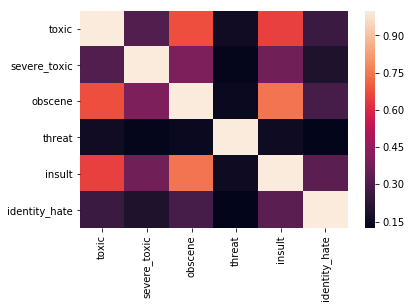

In [21]:
sns.heatmap(train[classes].corr())

## functions and classes

In [22]:
class standardize_text():
    def __init__(self):
        return
    
    def replace_entities(self, col):
        col = col.replace(r'\[WIKI_LINK\:\s[^\]]+\]', 'wikilink', regex=True)
        col = col.replace(r'\[EXTERNA_LINK\:\s[^\]]+\]', 'externalink', regex=True)
        col = col.replace(r'(https?\:\/\/|www)[^\s]+wikipedia[^\s]+', 'wikilink', regex=True)
        col = col.replace(r'(https?\:\/\/|www)[^\s]+[^wikipedia][^\s]+', 'externalink', regex=True)
        
        return col
    
    def clean(self, col):
        col = col.str.lower()
        col = col.replace(r'\n', ' ').replace(r'\t', ' ')
        col = col.replace(r'[^a-z\s]', '', regex=True)
        col = col.replace(r'\s+', ' ', regex=True)
        col = col.replace(r"([a-z]+?)\1+", r"\1\1", regex=True) # removes any repetitions of letters more than twice
        col = col.replace(r"\b(\w+)(\s)(\1\2?)+", r"\1", regex=True) # removes any repetitions of words more than once
        col = col.str.strip()
        
        return col

In [23]:
class create_count_features(BaseEstimator):
    def __init__(self):
        with open("../../External Data/badwords.txt") as f:
            badwords = [l.strip() for l in f.readlines()]
        self.badwords_ = badwords
        
    def fit(self, documents, y=None):
        return self

    def transform(self, documents):
        ## some handcrafted features!
        n_words = [len(c.split()) for c in documents]
        n_chars = [len(c) for c in documents]
        # number of uppercase words
        allcaps = [np.sum([w.isupper() for w in comment.split()])
               for comment in documents]
        # longest word
        max_word_len = [np.max([len(w) for w in c.split()]) for c in documents]
        # average word length
        mean_word_len = [np.mean([len(w) for w in c.split()])
                                            for c in documents]
        # number of google badwords:
        n_bad = [np.sum([c.lower().count(w) for w in self.badwords_])
                                                for c in documents]
        exclamation = [c.count("!") for c in documents]
        question = [c.count("?") for c in documents]
        newlines = [c.count("\n") for c in documents]
        tabs = [c.count("\t") for c in documents]
        wikilink = [c.count("wikilink") for c in documents]
        extralink = [c.count("externalink") for c in documents]
        spaces = [c.count(" ") for c in documents]

        allcaps_ratio = np.array(allcaps) / np.array(n_words, dtype=np.float)
        bad_ratio = np.array(n_bad) / np.array(n_words, dtype=np.float)

        return np.array([n_words, 
                         n_chars, 
                         allcaps, 
                         max_word_len,
                         mean_word_len, 
                         exclamation, 
                         question, 
                         tabs,
                         newlines,
                         wikilink, 
                         extralink, 
                         spaces, 
                         bad_ratio, 
                         n_bad, 
                         allcaps_ratio]).T
    
    def get_feature_names(self):
        return ['n_words', 
                 'n_chars', 
                 'allcaps', 
                 'max_word_len',
                 'mean_word_len', 
                 'exclamation', 
                 'question', 
                 'tabs',
                 'newlines',
                 'wikilink', 
                 'extralink', 
                 'spaces', 
                 'bad_ratio', 
                 'n_bad', 
                 'allcaps_ratio']

In [24]:
def train_best_model(pipe, parameters, X_train, y_train, X_val, y_val):
    predictions = pd.DataFrame()
    models = {}
    loss = 0
    for toxicity in classes:
        print(toxicity)
        est = GridSearchCV(pipe, 
                           parameters, 
                           scoring='neg_log_loss', 
                           n_jobs=-1,
                           cv=3, 
                           verbose=1)
        est.fit(X_train, y_train[toxicity])
        print(est.best_params_)
        print(est.best_score_)
        
        predictions[toxicity] = est.best_estimator_.predict_proba(X_val)[:, 1]
        models[toxicity] = est.best_estimator_
        
        ll = log_loss(y_val[toxicity], predictions[toxicity])
        print('>>> test log-loss: %s' % str(ll.round(3)))
        loss = loss + ll
        
    print('DONE! test mean log-loss: %s' % str(loss/6.))
    return predictions, models

## prepping features

In [62]:
st = standardize_text()

In [63]:
train['comment_text_clean'] = st.clean(st.replace_entities(train['comment_text']))
test['comment_text_clean'] = st.clean(st.replace_entities(test['comment_text']))

In [27]:
rs = ShuffleSplit(n_splits=1, test_size=0.2)

In [28]:
for j, k in rs.split(train):
    train_index = j
    val_index = k

In [64]:
X_train_df = train.loc[train_index, 'comment_text_clean'] 
X_val_df = train.loc[val_index, 'comment_text_clean']
y_train = train.loc[train_index, classes]
y_val = train.loc[val_index, classes]

In [65]:
X_train_cnt = st.replace_entities(train.loc[train_index, 'comment_text']) 
X_val_cnt = st.replace_entities(train.loc[val_index, 'comment_text'])
X_test_cnt = st.replace_entities(test.loc[:, 'comment_text'])

In [68]:
cnt_feat = create_count_features()
temp = pd.DataFrame(cnt_feat.transform(X_test_cnt), columns=cnt_feat.get_feature_names())

In [69]:
temp.mean()

n_words           69.547657
n_chars          418.093838
allcaps            2.333831
max_word_len      14.171812
mean_word_len      5.662057
exclamation        1.086952
question           0.309875
tabs               0.017731
newlines           1.624988
wikilink           1.386426
extralink          0.067719
spaces            68.632217
bad_ratio          0.010784
n_bad              0.642076
allcaps_ratio      0.036950
dtype: float64

### count based model

In [33]:
%%time
cnt_feat = create_count_features()
scaler = MinMaxScaler()
clf = RandomForestClassifier(n_estimators=200, class_weight=None, n_jobs=-1, bootstrap=True)  

pipe = Pipeline(steps=[('cnt', cnt_feat),
                       ('scaler', scaler), 
                       ('clf', clf)])

parameters = {'clf__max_depth':[5, 10],
              'clf__max_features': [3, 5, 10]}

cnt_predictions, cnt_models = train_best_model(pipe, parameters, X_train_cnt, y_train, X_val_cnt, y_val)

toxic
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 10.7min finished


{'clf__max_depth': 10, 'clf__max_features': 5}
-0.199992499049
>>> test log-loss: 0.194
severe_toxic
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 10.9min finished


{'clf__max_depth': 10, 'clf__max_features': 3}
-0.0283502357952
>>> test log-loss: 0.028
obscene
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 11.7min finished


{'clf__max_depth': 10, 'clf__max_features': 5}
-0.0959254347452
>>> test log-loss: 0.096
threat
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 10.7min finished


{'clf__max_depth': 10, 'clf__max_features': 3}
-0.0176145394103
>>> test log-loss: 0.015
insult
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 11.2min finished


{'clf__max_depth': 10, 'clf__max_features': 5}
-0.116962253393
>>> test log-loss: 0.116
identity_hate
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 11.3min finished


{'clf__max_depth': 10, 'clf__max_features': 3}
-0.0353031382521
>>> test log-loss: 0.036
DONE! test mean log-loss: 0.0807707119629
CPU times: user 7min 59s, sys: 5.35 s, total: 8min 5s
Wall time: 1h 12min 31s


In [48]:
joblib.dump(cnt_models, datetime.now().strftime('%Y%m%d%H%M')+'_cnt_models.pkl')

['201801021402_cnt_models.pkl']

### word level model

In [34]:
%%time
selec = SelectPercentile(chi2, percentile=20)
clf = LogisticRegression(C=5.0, class_weight=None, n_jobs=1)  
vect_words = TfidfVectorizer(max_features=None,
                             lowercase=False,
                             analyzer='word', 
                             ngram_range=(1, 3), 
                             max_df=0.1, 
                             min_df=3,
                             stop_words='english',
                             use_idf=True)

pipe = Pipeline(steps=[('vect', vect_words),
                       ('selec', selec), 
                       ('clf', clf)])

parameters = {'vect__ngram_range': [(1,1), (1,2)],
              'selec__percentile':[5, 10, 20], 
              'clf__C':[5, 10, 20]}

wd_predictions, wd_models = train_best_model(pipe, parameters, X_train_df, y_train, X_val_df, y_val)

toxic
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.8min finished


{'clf__C': 10, 'selec__percentile': 20, 'vect__ngram_range': (1, 1)}
-0.121924871403
>>> test log-loss: 0.115
severe_toxic
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.9min finished


{'clf__C': 5, 'selec__percentile': 10, 'vect__ngram_range': (1, 1)}
-0.0288962926679
>>> test log-loss: 0.028
obscene
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.8min finished


{'clf__C': 10, 'selec__percentile': 5, 'vect__ngram_range': (1, 1)}
-0.0650090594645
>>> test log-loss: 0.061
threat
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.8min finished


{'clf__C': 10, 'selec__percentile': 5, 'vect__ngram_range': (1, 1)}
-0.0117985050672
>>> test log-loss: 0.01
insult
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.8min finished


{'clf__C': 5, 'selec__percentile': 20, 'vect__ngram_range': (1, 1)}
-0.0842258663394
>>> test log-loss: 0.08
identity_hate
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.7min finished


{'clf__C': 5, 'selec__percentile': 10, 'vect__ngram_range': (1, 1)}
-0.027185635327
>>> test log-loss: 0.027
DONE! test mean log-loss: 0.0536270852381
CPU times: user 48.9 s, sys: 8.73 s, total: 57.6 s
Wall time: 23min 16s


In [49]:
joblib.dump(cnt_models, datetime.now().strftime('%Y%m%d%H%M')+'_wd_models.pkl')

['201801021407_wd_models.pkl']

### char level model

In [35]:
%%time
selec = SelectPercentile(chi2, percentile=20)
clf = LogisticRegression(C=5.0, class_weight=None, n_jobs=1)  
vect_words = TfidfVectorizer(max_features=None,
                             lowercase=False,
                             analyzer='char', 
                             ngram_range=(1, 5), 
                             max_df=0.1, 
                             min_df=3,
                             stop_words='english',
                             use_idf=True)

pipe = Pipeline(steps=[('vect', vect_words),
                       ('selec', selec), 
                       ('clf', clf)])

parameters = {'vect__ngram_range': [(1, 5), (2,4), (1,3)],
              'selec__percentile':[5, 10, 20], 
              'clf__C':[5, 10, 15]}

char_predictions, char_models = train_best_model(pipe, parameters, X_train_df, y_train, X_val_df, y_val)

toxic
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 52.5min finished


{'clf__C': 15, 'selec__percentile': 5, 'vect__ngram_range': (1, 5)}
-0.108849825167
>>> test log-loss: 0.101
severe_toxic
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 53.2min finished


{'clf__C': 5, 'selec__percentile': 10, 'vect__ngram_range': (2, 4)}
-0.0267918954029
>>> test log-loss: 0.027
obscene
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 52.7min finished


{'clf__C': 15, 'selec__percentile': 5, 'vect__ngram_range': (1, 5)}
-0.058170838787
>>> test log-loss: 0.056
threat
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 29.1min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 53.1min finished


{'clf__C': 15, 'selec__percentile': 5, 'vect__ngram_range': (2, 4)}
-0.0107006483618
>>> test log-loss: 0.009
insult
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 52.9min finished


{'clf__C': 10, 'selec__percentile': 5, 'vect__ngram_range': (1, 5)}
-0.0758156213287
>>> test log-loss: 0.072
identity_hate
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 52.7min finished


{'clf__C': 10, 'selec__percentile': 10, 'vect__ngram_range': (2, 4)}
-0.0248541566799
>>> test log-loss: 0.024
DONE! test mean log-loss: 0.0483288061892
CPU times: user 7min 28s, sys: 21.5 s, total: 7min 49s
Wall time: 5h 23min 48s


In [50]:
joblib.dump(cnt_models, datetime.now().strftime('%Y%m%d%H%M')+'_char_models.pkl')

['201801021408_char_models.pkl']

## stacking all models

In [36]:
pred_list = [wd_predictions, char_predictions, cnt_predictions]

In [55]:
%%time
predictions = pd.DataFrame()
loss = 0
models_stack = {}
X_train_stack = np.column_stack([x.values for x in pred_list])
for toxicity in classes:
    
    clf = LogisticRegression(C=10.0, class_weight=None, n_jobs=1)  
    
    est = GridSearchCV(clf, 
                       param_grid={'C': [1, 5, 10, 50, 200]}, 
                       scoring='neg_log_loss', 
                       n_jobs=-1,
                       cv=3, 
                       verbose=1)

    est.fit(X_train_stack, y_val[toxicity])
    
    predictions[toxicity] = est.best_estimator_.predict_proba(X_train_stack)[:,1]
    
    print(est.best_estimator_.coef_)
    print(est.best_params_)
    ll = log_loss(y_val[toxicity], predictions[toxicity])
    print('>>> test log-loss: %s' % str(ll.round(3)))
    loss = loss + ll
    
    models_stack[toxicity] = est.best_estimator_

print('DONE! test mean log-loss: %s' % str(loss/6.))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.8s finished


[[ 2.52420789  1.36660631  0.1855722   0.87292213  0.44255506 -0.77964703
   4.80939544  1.53813402  0.64881016 -0.03112045  0.06682059 -0.16901379
   6.25921718  1.19982127 -3.85100446  0.17740441 -1.38679172  0.25877916]]
{'C': 5}
>>> test log-loss: 0.109
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.9s finished


[[ 1.34243452  1.62459757  0.35859796 -0.55857024 -0.91947359 -2.28640436
   2.19975653  0.66221517  1.27285483  1.76669009  1.05841106  1.76138014
   5.65962082  3.85053213 -4.97278253  2.82075128  0.29090641 -3.20168416]]
{'C': 50}
>>> test log-loss: 0.022
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.8s finished


[[ 1.62571909  0.79157893  1.32386777 -0.57982234 -0.91375787 -0.92167856
   3.10616764  0.92835058  2.08406307 -0.06307052 -0.21540634 -0.11837457
   2.12076299 -0.87541523  0.20659599  0.0953532  -0.16920428  0.19672296]]
{'C': 1}
>>> test log-loss: 0.056
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.9s finished


[[ 3.73809336  2.08366911 -1.26348355  3.8811416   1.04259204 -1.74415985
   0.64629228 -2.77576838  0.26983686  4.78316943  0.21811793  1.08253751
  -0.94101383  0.03138877  0.45431638  2.07446177  0.70179611 -1.54523332]]
{'C': 10}
>>> test log-loss: 0.01
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.2s finished


[[ 1.06245    -0.66700854 -0.33010209 -0.76678814  0.72356112 -0.40687316
   4.23323804  0.52866694 -1.02899365  0.23736773  2.23529807  0.35133409
   2.4212437  -1.15407431 -3.4712238   1.54346245  2.74439269  0.62664992]]
{'C': 5}
>>> test log-loss: 0.07
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.2s finished


[[ 0.82425455  1.03787853 -0.09362501  0.39137003 -1.12495747  1.95629346
   3.71138067 -2.66871427 -1.07700237 -0.09108206  0.68145395  4.71526111
   0.38069681  0.31761359  0.66915146  0.80317123  0.98151084 -0.32435277]]
{'C': 5}
>>> test log-loss: 0.025
DONE! test mean log-loss: 0.0486234627443
CPU times: user 3.34 s, sys: 1.14 s, total: 4.47 s
Wall time: 14.9 s


## exploration of the results

In [38]:
df = pd.DataFrame(X_val_df.reset_index(drop=True))
df['label'] = y_val['toxic'].reset_index(drop=True)
df['pred'] = predictions['toxic']

In [39]:
def generate_cloud(col):
    text = '.. '.join(list(col))
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

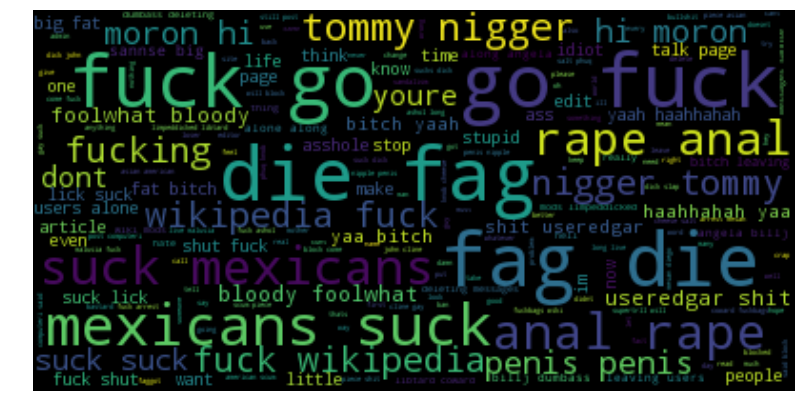

In [40]:
generate_cloud(df[(df.label==1) & (df.pred>0.5)].comment_text_clean)

In [41]:
df[df.comment_text_clean.str.contains('hate u')]

,comment_text_clean,label,pred
10196,sirmaam thank you for the heads up about needi...,0,0.015595


In [42]:
df[(df.label==0) & (df.pred>0.5)].comment_text_clean

119      are you andy greenwald because itd make a lot ...
155      as for wikilink this i also just asked if hes ...
178      the ridiculous vandalism on this page people l...
224      well you seem to feel free to add unwanted edi...
520      hi dear raimagini i would request all you all ...
867      im sorry but hes done pissed me off anyway do ...
892      talk page message no i was removing dreamguys ...
1036     let me ask u questshun sp y r u racist were wi...
1171     there is nothing uncivil about thatis a hell o...
1270                                  bellend ur a bellend
1525     revelation of a question was your mother a nig...
1576     you people stop attacking and telling lies abo...
1607     it is a watch that i own if i want to post a p...
1659     tmi page to the tosser wanna be admin ego mani...
1734     a bisexual like a homosexual or a heterosexual...
1773     i dont care to do what is right you cia scumba...
1814                        im scared brr im gonna die n

In [43]:
train[train.comment_text.str.contains('I promise you')]['comment_text']

23269    The solution without a reference \n\n  //  Y1+...
24603    I'm not prepared for you, I promise you 13 of ...
25627    "\n\nThis ""DavidShankBone"" has been personal...
36554    I only got blocked for spamming. I promise you...
38777    For now, I have lost. But I will come back wit...
53689    Legitimacy\n\nTo me, it has been an honor to b...
55133    Thank You So Much! \n\nToday, I thought I woul...
55336    I promise you the first thing I will do is hav...
57558    You're gonna pay for what you've done, Gregory...
63773    No information in any article was being based ...
66330    Your hobbies... \n\nMum's the word, I won't sa...
79413    "\n\n Editor review \n\nHey Nish, I'm currentl...
86899    "\n\n Please \nI promise you in not a BBHS. Pl...
Name: comment_text, dtype: object

# predictions on the test set

In [70]:
models_list = [(wd_models, test['comment_text_clean']), 
               (char_models, test['comment_text_clean']), 
               (cnt_models, X_test_cnt)]

In [73]:
%%time
all_results = []
for j, x in enumerate(models_list):
    print(j)
    for tox in classes:
        print('     '+tox)
        all_results.append(x[0][tox].predict_proba(x[1])[:,1])

0
     toxic
     severe_toxic
     obscene
     threat
     insult
     identity_hate
1
     toxic
     severe_toxic
     obscene
     threat
     insult
     identity_hate
2
     toxic
     severe_toxic
     obscene
     threat
     insult
     identity_hate
CPU times: user 30min 56s, sys: 8.83 s, total: 31min 5s
Wall time: 30min 41s


In [82]:
%%time
X_train_stack = np.column_stack(all_results)

CPU times: user 72 ms, sys: 8 ms, total: 80 ms
Wall time: 78.4 ms


In [87]:
%%time
predictions = pd.DataFrame(test.id)
loss = 0
for toxicity in classes:
    print(toxicity)
    predictions[toxicity] = models_stack[toxicity].predict_proba(X_train_stack)[:,1]

toxic
severe_toxic
obscene
threat
insult
identity_hate
CPU times: user 180 ms, sys: 0 ns, total: 180 ms
Wall time: 94.8 ms


In [ ]:
#%%time
#predictions = pd.DataFrame(test.id)
#loss = 0
#for toxicity in classes:
#    print(toxicity)
#    predictions[toxicity] = char_models[toxicity].predict_proba(test['comment_text_clean'])[:,1]

In [89]:
predictions.to_csv(datetime.now().strftime('%Y%m%d%H%M')+'_submission.csv', index=False)